# Generate a Network Model Grid on an OpenTopography DEM for the Puyallup River
<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>

<hr>

This notebook demonstrates how to create a NetworkModelGrid from a DEM hosted by OpenTopography. In this tutorial we will:
* Download a DEM from OpenTopography
* Reproject the DEM into a meter-based coordinate system (UTM-13)
* Clip the DEM to the largest watershed
* Create a NetworkModelGrid on the river system in this watershed using three different 'network_grid_from_raster' options

<hr>

*Note: Updated 5/21/2024 to use rioxarray*

In [1]:
# to add to github through terminal
#cd Goodrich
# git add puyallup-0.3-Goodrich.ipynb
# git commit -m "enter edit comments"
# git push "enter username and personal access token found on GitHub developer settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import rioxarray as rxr

import pandas as pd

from landlab import imshow_grid
from landlab.components import FlowDirectorSteepest, NetworkSedimentTransporter
from landlab.data_record import DataRecord
from landlab.grid.network import NetworkModelGrid
from landlab.plot import graph
from landlab.io import read_shapefile
from landlab.plot import plot_network_and_parcels

from bmi_topography import Topography
from rasterio.enums import Resampling

import shapefile

from landlab import RasterModelGrid

%matplotlib inline

## 1. Download DEM from OpenTopography using Topography utility

In [2]:
width = 0.05
dem = Topography(
    north=47.3358357629999986,
    south=46.7825014000000010,
    east=-121.3748169240000010,
    west=-122.4685226619999980 ,
    output_format="GTiff",
    dem_type="SRTMGL3",
    api_key='0b1844d3d39d5e6fb414e7d6f0ff6e3d'
)
dem.fetch()
_ = dem.load()

In [3]:
dst_crs="EPSG:32610"   # Destination coordinate reference system: UTM Zone 10 N (Washington)
scale_factor=2
transformed_array=dem.da.rio.reproject(dst_crs).astype('float')

reproj_array = transformed_array.rio.reproject(
    transformed_array.rio.crs,
    shape=(int(transformed_array.sizes['y']/scale_factor), int(transformed_array.sizes['x']/scale_factor)),
    resampling=Resampling.bilinear,
)

## 2. Clip Array Using Watershed Boundary Shapefile

In [4]:
datadir = pathlib.Path("puyallup_data")
shp_file = datadir / "puyallup_boundary.shp"

boundary = shapefile.Reader(shp_file)

In [5]:
clipped_array = reproj_array.rio.clip(boundary.shapes())
clipped_bounds=clipped_array.rio.bounds()

In [6]:
no_dataval = -9999
mask_array = clipped_array.copy()
mask_array.data = no_dataval*np.ones_like(clipped_array.data)
mask_array = mask_array.rio.clip(boundary.shapes(),invert=True)
masked_clipped_array = mask_array + clipped_array
masked_clipped_array.attrs=reproj_array.attrs # Not sure if I need to do this
masked_clipped_array.rio.set_nodata(-9999) # Not sure if I need to do this

<xarray.DataArray 'SRTMGL3' (band: 1, y: 430, x: 593)>
array([[[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ..., 
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]]])
Coordinates:
  * x            (x) float64 5.402e+05 5.403e+05 ... 6.233e+05 6.234e+05
  * y            (y) float64 5.242e+06 5.242e+06 ... 5.182e+06 5.182e+06
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    units:          degrees
    _FillValue:     0.0

## 3. Create Landlab Grid

In [7]:
target_res=50
grid = RasterModelGrid(
    (masked_clipped_array.sizes['y'], masked_clipped_array.sizes['x']),
    xy_spacing=target_res,
    xy_of_lower_left=(clipped_bounds[0],clipped_bounds[1]),
    xy_axis_name=("X UTM10", "Y UTM10"),
    xy_axis_units="m",
)
z = np.ravel(np.flipud(masked_clipped_array.values[0]))
grid.at_node["topographic__elevation"] = z

In [8]:
grid.status_at_node[np.isclose(z, masked_clipped_array.rio.nodata)] = grid.BC_NODE_IS_CLOSED
# I think I still need to do this

_Note: I deleted the section in the tutorial where it ran FlowAccumulator, since we figured out the watershed boundary with the shapefile. However, I did try FlowAccumulator, and it did not run._

## 4. Set a watershed boundary condition for your grid

In [9]:
grid.at_node["topographic__elevation"].data[141230]=-9999

In [10]:
 grid.set_watershed_boundary_condition(
     'topographic__elevation',
     nodata_value=-9999,
     return_outlet_id=True
 )

array([218844])

In [11]:
grid.set_watershed_boundary_condition_outlet_id(
    [218844],
    "topographic__elevation",
)

In [12]:
mca_v=xr.where(masked_clipped_array.values>masked_clipped_array.rio.nodata,masked_clipped_array.values,np.nan).ravel()
print(np.nanmean(mca_v),np.nanmax(mca_v))

848.713353249 4331.02436798


## 5. Create a NetworkModelGrid on this topography

In [13]:
from landlab.grid.create_network import (
    AtMostNodes,
    SpacingAtLeast,
    network_grid_from_raster,
    spacing_from_drainage_area,
)
from landlab.plot.graph import plot_links, plot_nodes

In [14]:
network_grid = network_grid_from_raster(
    grid,
    minimum_channel_threshold=5000000,  # upstream drainage area to truncate network, in m^2
    include=["drainage_area", "topographic__elevation"],
)

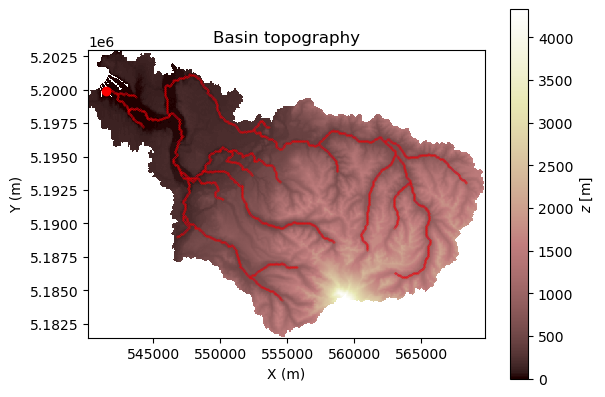

In [15]:
imshow_grid(
    grid,
    "topographic__elevation",
    plot_name="Basin topography",
    color_for_closed=None,
    colorbar_label="$z$ [m]",
)

# Plot network_grid (river channel) 
plot_links(network_grid, with_id=False, as_arrow=False, linewidth=0.05)
plot_nodes(network_grid, with_id=False, markersize=0.2)

# Plot outlet
coords_outlet=grid.xy_of_node[218844]
plt.plot(coords_outlet[0],coords_outlet[1],'ro')

In [16]:
def my_plot_links(
    graph, color="b", linestyle="solid", with_id=True, as_arrow=True, linewidth=None, textsize=16
):
    if as_arrow:
        head_width = 0.1
    else:
        head_width = 0.0
    for link, nodes in enumerate(graph.nodes_at_link):
        x, y = graph.x_of_node[nodes[0]], graph.y_of_node[nodes[0]]
        dx, dy = graph.x_of_node[nodes[1]] - x, graph.y_of_node[nodes[1]] - y
        plt.arrow(
            x,
            y,
            dx,
            dy,
            head_width=head_width,
            linewidth=linewidth,
            length_includes_head=True,
            color=color,
            linestyle=linestyle,
        )
        if with_id:
            plt.text(x + dx * 0.5, y + dy * 0.5, link, size=textsize, color=color)

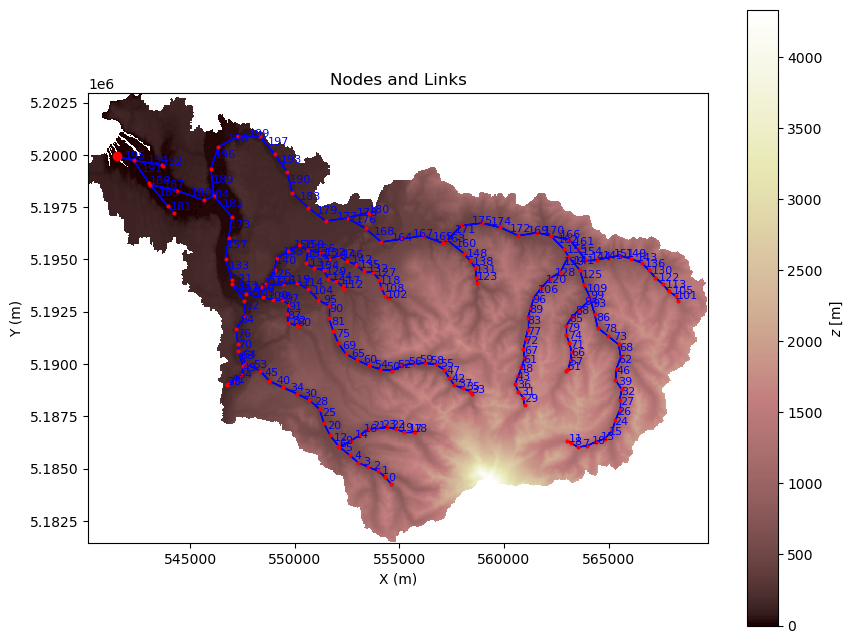

In [17]:
plt.figure(figsize=(10,8))
spacing = spacing_from_drainage_area(
    grid.at_node["drainage_area"], a=9.68, b=0.32, n_widths=100
)

network_grid = network_grid_from_raster(
    grid,
    reducer=SpacingAtLeast(grid.xy_of_node, spacing),
    minimum_channel_threshold=5000000,
    include=["drainage_area", "topographic__elevation"],
)

imshow_grid(
    grid,
    "topographic__elevation",
    plot_name="Basin topography",
    color_for_closed=None,
    colorbar_label="$z$ [m]",
)

plot_nodes(network_grid, with_id=False, markersize=2)
my_plot_links(network_grid, with_id=True, as_arrow=False, textsize=8)
plt.plot(coords_outlet[0],coords_outlet[1],'ro', markersize=6)
plt.title("Nodes and Links");

**There are problems with the network grid plotted above.** Link numbers are _not_ ordered from upstream to downstream (which I think Network Sediment Transporter assumes is true). For example, link 197 - near the northernmost edge of the watershed - is upstream of 196. I believe this is one of the issues that causes problems with `locate_parcel_xy` in `plot_network_and_parcels` below.

## 6. Create Sediment Parcels and Populate Network Grid

Note: the following characteristics of the network model grid are set in the river channel shapefile in the tutorial. Because we determine the network grid from topography, we need to set them. These values may not be physically reasonable.

In [18]:
network_grid.at_node["bedrock__elevation"] = network_grid.at_node["topographic__elevation"].copy()

network_grid.at_link["channel_width"] = 85 * np.ones(network_grid.number_of_links) # m (nearest reasonable google search for WR=5) 

network_grid.at_link["flow_depth"] = 4 * np.ones(network_grid.number_of_links) # m (rough estimate based on gage ht data in white river monitor zones= 33.95)
network_grid.at_link["reach_length"] = network_grid.length_of_link

In [19]:
# element_id is the link on which the parcel begins. 
#assign stream order width and depth?
element_id = np.repeat(np.arange(network_grid.number_of_links), 300)
element_id = np.expand_dims(element_id, axis=1)

volume = 1*np.ones(np.shape(element_id))  # (m3)
active_layer = np.ones(np.shape(element_id)) # 1= active, 0 = inactive
density = 2650 * np.ones(np.size(element_id))  # (kg/m3)
abrasion_rate = 0 * np.ones(np.size(element_id)) # (mass loss /m)
distance_traveled= 0 * np.ones((np.size(element_id),1)) #(m)

# Lognormal GSD
medianD = 0.1 # m (medium sand diameter, 0.5cm or 0.0005m) 10^-1, 0.10=(10^-2, 10^0)
mu = np.log(medianD)
sigma = np.log(2) #assume that D84 = sigma*D50
np.random.seed(0)
D = np.random.lognormal(
    mu,
    sigma,
    np.shape(element_id)
)  # (m) the diameter of grains in each parcel

In [20]:
time_arrival_in_link = np.random.rand(np.size(element_id), 1) 
location_in_link = np.random.rand(np.size(element_id), 1) 

In [21]:
lithology = ["andesite"] * np.size(element_id) #where we will insert characteristics 
#magnetic suscepeblilty, iron oxide characteristics, etc.

In [22]:
variables = {
    "abrasion_rate": (["item_id"], abrasion_rate),
    "density": (["item_id"], density),
    "lithology": (["item_id"], lithology),
    "time_arrival_in_link": (["item_id", "time"], time_arrival_in_link),
    "active_layer": (["item_id", "time"], active_layer),
    "location_in_link": (["item_id", "time"], location_in_link),
    "distance_traveled": (["item_id", "time"], distance_traveled),
    "D": (["item_id", "time"], D),
    "volume": (["item_id", "time"], volume)
}

In [23]:
items = {"grid_element": "link", "element_id": element_id}

parcels = DataRecord(
    network_grid,
    items=items,
    time=[0.0],
    data_vars=variables,
    dummy_elements={"link": [NetworkSedimentTransporter.OUT_OF_NETWORK]},
)

## 7. Run Network Sediment Transporter

In [24]:
timesteps = 30 # total number of timesteps
#dt = 60 * 60 * 24 *2 # length of timestep (seconds) 
dt = 60 * 60 * 3 # 3 hour steps

In [25]:
fd = FlowDirectorSteepest(network_grid, "topographic__elevation")
fd.run_one_step()

In [26]:
D=pd.DataFrame()
D['active_links']=network_grid.active_links
D['flow_direction']=network_grid.at_link['flow__link_direction']
problem_links = list(D[D['flow_direction']==0]['active_links'])
display(problem_links)
coords=np.array([list(network_grid.xy_of_link[x]) for x in problem_links])

[6, 14, 34, 41, 49, 99, 167, 189]

In [27]:
network_grid.at_link['flow__link_direction']=np.array(list([x if (x != 0) else 1 for x in network_grid.at_link['flow__link_direction']]))

In [28]:
nst = NetworkSedimentTransporter(    
    network_grid,
    parcels,
    fd,
    bed_porosity=0.3,
    g=9.81,
    fluid_density=1000,
    transport_method="WilcockCrowe", #discuss other transport methods
)

In [29]:
time_range=range(0, (timesteps * dt), dt)
sediment_volume=np.zeros_like(time_range)
item_ids=parcels.dataset['item_id'].values
i=0

for t in range(0, (timesteps * dt), dt):
    nst.run_one_step(dt)
    
    distances=np.array(nst._distance_traveled_cumulative)
    parcels.dataset['distance_traveled']=xr.where(parcels.dataset.time==t,
                                                  distances,parcels.dataset['distance_traveled'])
    print(parcels.dataset.sel(time=t)['distance_traveled'].values)
    print(distances)
    

    print("Model time: ", t / (60 * 60 * 24), "days passed")
    sediment_volume[i]=network_grid.at_link['sediment_total_volume'].sum()
    i+=1
    

[ 399.45834988  475.88853149  454.97008196 ...,   64.53556972   83.36476037
   74.85305588]
[ 399.45834988  475.88853149  454.97008196 ...,   64.53556972   83.36476037
   74.85305588]
Model time:  0.0 days passed
[ 756.29405541  901.88927807  862.10438317 ...,  132.02820425  119.48055494
  153.00689419]
[ 756.29405541  901.88927807  862.10438317 ...,  132.02820425  119.48055494
  153.00689419]
Model time:  0.125 days passed
[ 8056.63061137  1097.23750552  1046.69954155 ...,   200.40169937
   154.69132577   232.05326372]
[ 8056.63061137  1097.23750552  1046.69954155 ...,   200.40169937
   154.69132577   232.05326372]
Model time:  0.25 days passed
[ 8056.63061137  1404.52708974  1205.53079142 ...,   270.83662331
   188.34576657   313.38065072]
[ 8056.63061137  1404.52708974  1205.53079142 ...,   270.83662331
   188.34576657   313.38065072]
Model time:  0.375 days passed
[ 8056.63061137  1537.49186328  1330.03295762 ...,   340.15057474
   222.22817156   393.40141096]
[ 8056.63061137  1537

## 8. Plot Parcels and Network

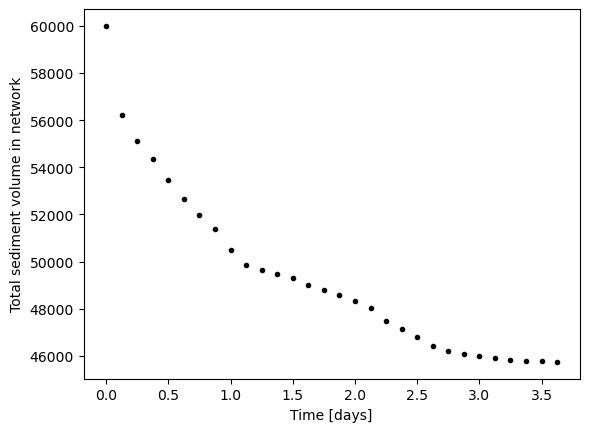

In [30]:
plt.plot(np.array(time_range)/(60*60*24),sediment_volume,'k.')
plt.xlabel('Time [days]')
plt.ylabel('Total sediment volume in network')
plt.show()

Added the following for error checking.

I think the issue with plotting has to do with some links in the network model grid where the flow directions are 0 (a case that `locate_parcel_xy` does not handle). These seem to occur near confluences, and may be related to places where the numbering does not increase downstream.

Here is where the problems happen (orange crosses):

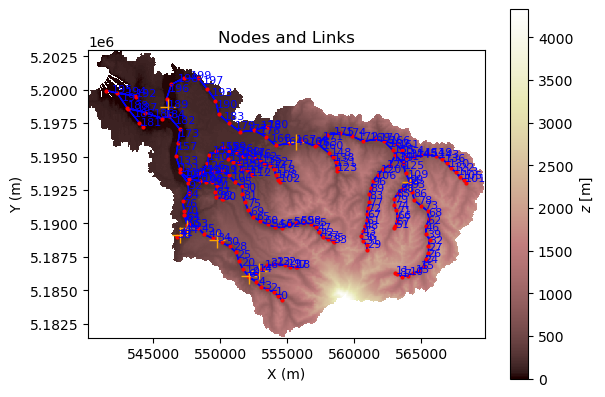

In [31]:

spacing = spacing_from_drainage_area(
    grid.at_node["drainage_area"], a=9.68, b=0.32, n_widths=100
)

imshow_grid(
    grid,
    "topographic__elevation",
    plot_name="Basin topography",
    color_for_closed=None,
    colorbar_label="$z$ [m]",
)

plot_nodes(network_grid, with_id=False, markersize=2)
my_plot_links(network_grid, with_id=True, as_arrow=False, textsize=8)
plt.plot(coords[:,0],coords[:,1],'+',color='orange',markersize=12)
plt.title("Nodes and Links");

For now, let's just fix the problem by setting the flow directions in the problem links to -1.

I had to add the following code in to allow us to track the originating links of each parcel for plotting

In [88]:
originating_links=np.reshape(np.repeat(parcels.dataset.element_id[:,0].values,np.array(time_range).shape[0]+1),(parcels.dataset.element_id[:,0].values.shape[0],np.array(time_range).shape[0]+1)).T
parcels.dataset['originating_link']=xr.DataArray(originating_links,coords=parcels.dataset.coords)

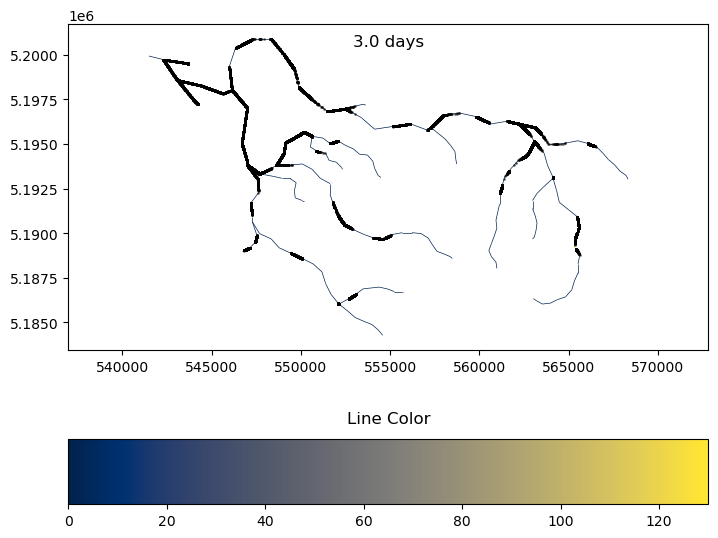

,link,volume
0,0.0,0.0
1,1.0,0.0
2,2.0,0.0
3,3.0,0.0
4,4.0,0.0
5,5.0,0.0
6,6.0,0.0
7,7.0,0.0
8,8.0,0.0
9,9.0,0.0


In [32]:
timestep_of_interest = 24
originating_link = 11 # This is Emmons Glacier (I think)


# filter the parcels to calculate total volumes of only the parcels that originated in the chosen link
parcelfilter = np.zeros_like(parcels.dataset.element_id, dtype=bool)
parcelfilter[:, timestep_of_interest] = (
    parcels.dataset.element_id[:, 0] == originating_link #sets parcel values to either 1 or 0, if it is from origninating link or not
)

vol_orig_link = parcels.calc_aggregate_value(
    xr.Dataset.sum, "volume", at="link", filter_array=parcelfilter, fill_value=0.0 #sums up volume of each link, determines if each parcel in that link is from original link
)

fig = plot_network_and_parcels(
    network_grid,
    parcels,
    link_attribute=vol_orig_link,
    parcel_time_index=timestep_of_interest,
    network_linewidth=0.5,
    parcel_alpha=0.5,

)
#fig = plot_network_and_parcels(
    #network_grid,
    #parcels,
    #link_attribute=vol_orig_link,
    #parcel_time_index=timestep_of_interest,
    #network_linewidth=2.5,
    #parcel_alpha=0,

#)
fig.suptitle('{} days'.format(timestep_of_interest/8))
plt.show()

with pd.option_context("display.max_rows", 1000):
   display(pd.DataFrame(data=np.array([network_grid.active_links,vol_orig_link]).T,columns=['link','volume']))

The following statement lists out how far each parcel from the originating link has traveled at the timestep of intrest. Note that a few have gone over 20 km.

In [105]:
print(parcels.dataset["distance_traveled"].where((parcels.dataset.time==timestep_of_interest*dt)&(parcels.dataset.originating_link==originating_link),drop=True).values.flatten().T)

[  5449.32426833   5901.37176682   6137.35744218   4696.92226196
   4719.33926539   5458.11523465   4781.11940445   5966.22641986
   5444.87227465   4867.14641378   5656.2328382    4762.6794171
   6217.6066018    4847.94109369   5733.19264251   6271.92441324
   6144.84164974   5506.83634382   4852.60894566   5390.87686139
   4806.20358806   5796.95513369   4943.61910569   4750.17436399
   5612.59224728   4731.13318281   5640.858194     5495.76398511
   5476.33075251   4834.09484909   5752.03881589   4865.91262589
   4895.96825651   4807.98278422  20774.89350882   4768.53426072
   5709.02028757   4866.2086268    4737.3582461    4728.02372094
   6089.83933732   6234.73524302   5432.20372678   5554.94959024
   4775.94856816   4879.50416004   5646.12331599   4848.00520391
   5675.20559178   4722.96155245   4854.99663492   4736.43608184
   4881.68342188   4678.20743176   4649.43786843   4812.35328561
   5471.80144594   5837.26839882   5467.91510552   5731.2034397
   5907.34360862   5621.493

Plot of distance traveled vs. time:

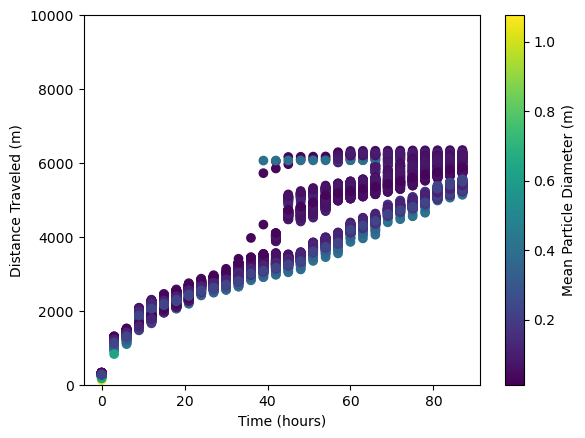

In [126]:
parcel_subset=parcels.dataset.where((parcels.dataset.originating_link==originating_link),drop=True)
parcel_subset_df=parcel_subset.to_dataframe().reset_index()
fig, ax = plt.subplots()
p=ax.scatter(parcel_subset_df['time']/(60*60),parcel_subset_df['distance_traveled'],c=parcel_subset_df['D'])
cb=fig.colorbar(p)
plt.xlabel('Time (hours)')
plt.ylabel('Distance Traveled (m)') 
plt.ylim(0,10000)
cb.ax.set_ylabel('Mean Particle Diameter (m)') 
plt.show()

In [ ]:
fig = plot_network_and_parcels(
    network_grid, parcels, 
    parcel_time_index=0, 
    parcel_color_attribute="D",
    link_attribute="sediment_total_volume", 
    parcel_size=10, 
    parcel_alpha=0,
)
#with pd.option_context("display.max_rows", 1000):
  #display(pd.DataFrame(data=np.array([network_grid.active_links,vol_orig_link]).T,columns=['link','volume']))

# sediment total volume

In [ ]:
plt.loglog(parcels.dataset.D[:,-1],
         nst._distance_traveled_cumulative,
         '.'
        )
plt.xlabel('Parcel grain size (m)')
plt.ylabel('Cumulative parcel travel distance')

# Note: some of the smallest grain travel distances can exceed the length of the 
# grid by "overshooting" during a single timestep of high transport rate

# parcels moving out of system

In [ ]:
out_of_system=parcels.dataset.where(parcels.dataset.element_id==-2,drop=True).item_id
print(out_of_system)

## Plotting Sediment Volume

In [ ]:
from matplotlib.colors import Normalize
network_norm = Normalize(-1, 300) # see matplotlib.colors.Normalize (************SEDIMENT VOLUME SCALE)
 
link_color_options = [
    {
        "link_attribute": "sediment_total_volume", 
        "network_norm": network_norm, # and normalize color scheme
        "link_attribute_title": "Total Sediment Volume", # title on link color legend
        "network_cmap": "plasma",
        "parcel_alpha":0, 
        "network_linewidth":3 

    }
]

In [ ]:
for grid, parcels in zip([grid], [parcels]):
    for l_opts in link_color_options:
        fig = plot_network_and_parcels(
        network_grid, parcels, 
        parcel_time_index=0, **l_opts)
    ax=plt.gca()
    #ax.plot(coords[:,0],coords[:,1],'+',color='orange',markersize=12)
plt.show()
#plot_nodes(network_grid, with_id=False, markersize=2)
#my_plot_links(network_grid, with_id=True, as_arrow=False, textsize=8)
#plt.plot(coords[:,0],coords[:,1],'+',color='orange',markersize=12)

In [ ]:
for l_opts in link_color_options:
    fig = plot_network_and_parcels(
        network_grid, parcels, 
        parcel_time_index=9, **l_opts)
    ax=plt.gca()
    #ax.plot(coords[:,0],coords[:,1],'+',color='orange',markersize=12)
plt.show()

## 6. Plotting a subset of the parcels

In some cases, we might want to plot only a subset of the parcels on the network. Below, we plot every 500th parcel in the `DataRecord`. 

In [ ]:
#parcel_filter = np.zeros((parcels.dataset.dims["item_id"]), dtype=bool)
#parcel_filter[::500] = True
import matplotlib.colors as colors
from matplotlib.colors import Normalize

parcel_color_norm = Normalize(-1, 300) # Linear normalization
parcel_color_norm=colors.LogNorm(vmin=0.01, vmax=0.1) #ADJUST THIS WHEN SETTING MEDIAN DIAMETER
originating_link=11


# filter the parcels to calculate total volumes of only the parcels that originated in the chosen link
parcel_filter = np.zeros_like(parcels.dataset.element_id, dtype=bool)
for t in range(0,timesteps):
    parcel_filter[:, t] = (
        parcels.dataset.element_id[:, 0] == originating_link #sets parcel values to either 1 or 0, if it is from origninating link or not
    )

    
pc_opts= {
        "parcel_color_attribute": "D", # a more complex normalization and a parcel filter. 
        "parcel_color_norm": parcel_color_norm,
        "parcel_color_attribute_title":"Diameter [m]",
        "parcel_alpha": 1.0,
        "parcel_size": 40,
        "parcel_time_index":0,
        "parcel_filter": parcel_filter[:,0]
    }
fig = plot_network_and_parcels(
    network_grid, parcels, 
    **pc_opts
)
pc_opts2= {
        "parcel_color_attribute": "D", # a more complex normalization and a parcel filter. 
        "parcel_color_norm": parcel_color_norm,
        "parcel_color_attribute_title":"Diameter [m]",
        "parcel_alpha": 1.0,
        "parcel_size": 40,
        "parcel_time_index":24,
        "parcel_filter": parcel_filter[:,24]
    }
fig = plot_network_and_parcels(
    network_grid, parcels, 
    **pc_opts2
    )
plt.show()

In [ ]:
#parcel_vol_on_grid = parcels.dataset["volume"].values
#parcel_vol_on_grid[parcels.dataset["element_id"].values==-2]=0
#parcel_filter = np.zeros_like(parcels.dataset.element_id, dtype=bool)
#for t in range(0,timesteps):
   # parcel_filter[:, t] = (
     #   parcels.dataset.element_id[:, 0] == originating_link #sets parcel values to either 1 or 0, if it is from origninating link or not
   # )

#travel_distance=nst._distance_traveled_cumulative,"parcel_filter"== parcel_filter[:,0]
print(travel_distance)

## 4. Options for parcel color

The dictionary below (`parcel_color_options`) outlines 4 examples of link color and line width choices: 

3. Color parcels by an existing parcel attribute, in this case the sediment diameter of the parcel (`parcels1.dataset['D']`)


In [ ]:
import matplotlib.colors as colors

parcel_filter = np.zeros((parcels.dataset.dims["item_id"]), dtype=bool)
parcel_filter[::500] = True



parcel_color_options = [
    {
        "parcel_color_attribute": "D", # existing parcel attribute. 
        "parcel_color_norm": parcel_color_norm,
        "parcel_color_attribute_title":"Diameter [m]",
        "parcel_alpha":1.0,
    },
]

for grid, parcels in zip([grid], [parcels]):
    for pc_opts in parcel_color_options:
        fig = plot_network_and_parcels(
            network_grid, parcels, 
            parcel_time_index=0, **pc_opts)
        plt.show()



## 5. Options for parcel size
The dictionary below (`parcel_size_options`) outlines 4 examples of link color and line width choices: 
1. The default output of `plot_network_and_parcels`
2. Set a uniform parcel size and color
3. Size parcels by an existing parcel attribute, in this case the sediment diameter (`parcels1.dataset['D']`), and making the parcel markers entirely opaque. 
4. Normalize parcel size on a logarithmic scale, and change the default maximum and minimum parcel sizes. 

## 7. Select the parcel timestep to be plotted

As a default, `plot_network_and_parcels` plots parcel positions for the last timestep of the model run. However, `NetworkSedimentTransporter` tracks the motion of parcels for all timesteps. We can plot the location of parcels on the link at any timestep using `parcel_time_index`. 

In [ ]:
parcel_time_options = [0,9,20]

for grid, parcels in zip([grid], [parcels]):
    for pt_opts in parcel_time_options:
        fig = plot_network_and_parcels(
            network_grid, parcels, 
            parcel_size = 20,
            parcel_alpha = 0.1,
            parcel_time_index=pt_opts)
        plt.show()

## filtering for originating link (experiment)